# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

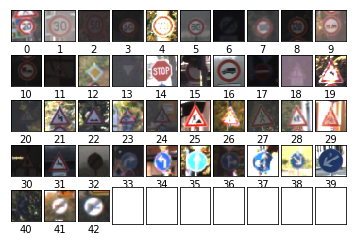

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
import cv2
# Visualizations will be shown in the notebook.
%matplotlib inline

# Plot traffic sign images
def visualizing(X_train=X_train):
    examples = [np.where(y_train == sign)[0][0] for sign in range(n_classes)]
    figure, axes = plt.subplots(5, 10)
    figure.subplots_adjust(hspace=0.2, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        if i < n_classes:
            ax.imshow(X_train[examples[i]].squeeze())
            ax.set_xlabel("{0}".format(i))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

visualizing()

Text(0,0.5,'Count')

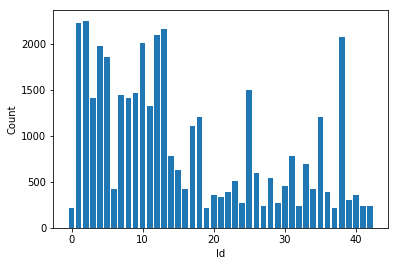

In [4]:
# Plot the count of each  sign
plt.bar(range(n_classes), [sum(y_train == sign) for sign in range(n_classes)])
plt.xlabel("Id")
plt.ylabel("Count")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def preprocessing(image):
    for i in range(3):
        image[:,:,i] = cv2.equalizeHist(image[:,:,i])
        
    return image / 255.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** For brightness normalization, histogram equalization is used on each channel; then implement the Min-Max scaling for the data which bring values of all images into the range [0, 1].

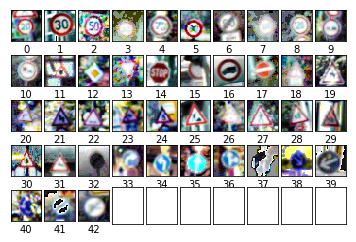

In [6]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
def transforming(image, trans_range, angle_range):
    # Random rotation
    row,col,_ = image.shape
    ang_rot = np.random.uniform(angle_range)-angle_range/2
    Rot_M = cv2.getRotationMatrix2D((col/2,row/2),ang_rot,1)
    reflect = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_REFLECT)
    image = cv2.warpAffine(reflect,Rot_M,(col+20,row+20))[10:col+10,10:row+10,:]
    
    # Random translation
    trans_x = trans_range*np.random.uniform()-trans_range/2
    trans_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,trans_x],[0,1,trans_y]])
    reflect = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_REFLECT)
    image = cv2.warpAffine(reflect,Trans_M,(col+20,row+20))[10:col+10,10:row+10,:]
    
    # Brightness augmentation
    dst = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    dst[:,:,2] = dst[:,:,2]*(0.1+np.random.uniform())
    image = cv2.cvtColor(dst,cv2.COLOR_HSV2RGB)
    
    return preprocessing(image)

X_trans = np.array([transforming(image, 3, 20) for image in X_train], dtype=np.float32)
visualizing(X_trans)

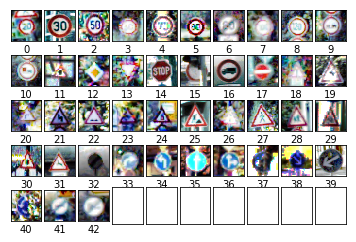

In [7]:
X_train = np.array([preprocessing(image) for image in X_train], dtype=np.float32)
visualizing(X_train)

In [8]:
X_train = np.vstack((X_train, X_trans))
X_test = np.array([preprocessing(image) for image in X_test], dtype=np.float32)
print('New data shape', X_train.shape)
y_train = np.hstack((y_train, y_train))
print('New label shape', y_train.shape)

New data shape (78418, 32, 32, 3)
New label shape (78418,)


In [9]:
from sklearn.cross_validation import train_test_split
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train[indices] = X_train
y_train[indices] = y_train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('Classes in training set', len(set(y_train)))
print('Classes in validation set', len(set(y_valid)))
print('Classes in test set', len(set(y_test)))

print('Training set', X_train.shape, ', y_train', y_train.shape)
print('Validation set', X_valid.shape, ', y_valid', y_valid.shape)
print('Test set', X_test.shape, ', y_test', y_test.shape)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Classes in training set 43
Classes in validation set 43
Classes in test set 43
Training set (62734, 32, 32, 3) , y_train (62734,)
Validation set (15684, 32, 32, 3) , y_valid (15684,)
Test set (12630, 32, 32, 3) , y_test (12630,)


In [10]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train).astype(np.float32)
y_valid = lb.transform(y_valid).astype(np.float32)
y_test = lb.transform(y_test).astype(np.float32)

import os
augmenting_file = 'augment.p'
if not os.path.isfile(augmenting_file):
    print('Caching data...')
    try:
        with open(augmenting_file, 'wb') as f:
            pickle.dump({
                'X_train': X_train,
                'y_train': y_train,
                'X_valid': X_valid,
                'y_valid': y_valid,
                'X_test': X_test,
                'y_test': y_test
            }, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Can\'t cache data: ', e)
        raise

In [11]:
import tensorflow as tf

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** The image data is split into training and validation sets using sklearn's train_test_split function so that 80% in training data and 20% in validation data.  One additional dataset is generated by applying random rotation, random translation, and brightness augmentation to all images of the original dataset.  The random rotation is set to +/-10 degrees; then images are shifted randomly in both the x and y directions; and brightness is randomly augmented on training images.  The new data is included in order to make the neural network insensitive to these changes.  Their differences can be easily seen through the above visualization.

In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def conv_layer(input, num_in_channels, filter_size, num_filters, use_pooling=True):
    shape = [filter_size, filter_size, num_in_channels, num_filters]
    weights = init_weights(shape)
    biases = init_biases(num_filters)
    layer = tf.add(tf.nn.conv2d(input=input, filter = weights, strides=[1,1,1,1], padding='SAME'), biases)
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return tf.nn.relu(layer), weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    return tf.reshape(layer, [-1,num_features]), num_features

def fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = init_weights([num_inputs, num_outputs])
    biases = init_biases(num_outputs)
    layer = tf.add(tf.matmul(input, weights), biases)
    return tf.nn.relu(layer) if use_relu else layer, weights

def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def init_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

img_size = 32
num_channels = 3

tf.reset_default_graph()
x_image = tf.placeholder(tf.float32, [None,img_size,img_size,num_channels], name='x')
y_true = tf.placeholder(tf.float32, [None,n_classes], name='y_true')
y_true_class = tf.argmax(y_true, dimension=1)
keep_prob = tf.placeholder(tf.float32)

# Convolutional layer 1
filter_size1 = 5
num_filters1 = 32
# Convolutional layer 2
filter_size2 = 5
num_filters2 = 32
# Convolutional layer 3
filter_size3 = 5
num_filters3 = 64
# Convolutional layer 4
filter_size4 = 5
num_filters4 = 64
# Convolutional layer 5
filter_size5 = 5
num_filters5 = 128
# Convolutional layer 6
filter_size6 = 5
num_filters6 = 128

# Fully-connected layer 1
fc_size1 = 1024
# Fully-connected layer 2
fc_size2 = 1024

layer_conv1, weights_conv1 = \
    conv_layer(input=x_image,num_in_channels=num_channels,filter_size=filter_size1,num_filters=num_filters1,use_pooling=False)
layer_conv1

Instructions for updating:
Use the `axis` argument instead


<tf.Tensor 'Relu:0' shape=(?, 32, 32, 32) dtype=float32>

In [13]:
layer_conv2, weights_conv2 = \
    conv_layer(input=layer_conv1,num_in_channels=num_filters1,filter_size=filter_size2,num_filters=num_filters2)
layer_conv2_drop = tf.nn.dropout(layer_conv2, keep_prob)
layer_conv2, layer_conv2_drop

(<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 32) dtype=float32>,
 <tf.Tensor 'dropout/mul:0' shape=(?, 16, 16, 32) dtype=float32>)

In [14]:
layer_conv3, weights_conv3 = \
    conv_layer(input=layer_conv2_drop,num_in_channels=num_filters2,filter_size=filter_size3,num_filters=num_filters3,use_pooling=False)
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 64) dtype=float32>

In [15]:
layer_conv4, weights_conv4 = \
    conv_layer(input=layer_conv3,num_in_channels=num_filters3,filter_size=filter_size4,num_filters=num_filters4)
layer_conv4_drop = tf.nn.dropout(layer_conv4, keep_prob)
layer_conv4, layer_conv4_drop

(<tf.Tensor 'Relu_3:0' shape=(?, 8, 8, 64) dtype=float32>,
 <tf.Tensor 'dropout_1/mul:0' shape=(?, 8, 8, 64) dtype=float32>)

In [16]:
layer_conv5, weights_conv5 = \
    conv_layer(input=layer_conv4_drop,num_in_channels=num_filters4,filter_size=filter_size5,num_filters=num_filters5,use_pooling=False)
layer_conv5

<tf.Tensor 'Relu_4:0' shape=(?, 8, 8, 128) dtype=float32>

In [17]:
layer_conv6, weights_conv6 = \
    conv_layer(input=layer_conv5,num_in_channels=num_filters5,filter_size=filter_size6,num_filters=num_filters6)
layer_conv6_drop = tf.nn.dropout(layer_conv6, keep_prob)
layer_conv6, layer_conv6_drop

(<tf.Tensor 'Relu_5:0' shape=(?, 4, 4, 128) dtype=float32>,
 <tf.Tensor 'dropout_2/mul:0' shape=(?, 4, 4, 128) dtype=float32>)

In [18]:
layer_flat2, num_features2 = flatten_layer(layer_conv2_drop)
layer_flat4, num_features4 = flatten_layer(layer_conv4_drop)
layer_flat6, num_features6 = flatten_layer(layer_conv6_drop)
layer_flat = tf.concat([layer_flat2, layer_flat4, layer_flat6], 1)
num_features = num_features2 + num_features4 + num_features6
layer_flat

<tf.Tensor 'concat:0' shape=(?, 14336) dtype=float32>

In [19]:
layer_fc1, weights_fc1 = fc_layer(layer_flat,num_features,fc_size1)
layer_fc1_drop = tf.nn.dropout(layer_fc1, keep_prob)
layer_fc1, layer_fc1_drop

(<tf.Tensor 'Relu_6:0' shape=(?, 1024) dtype=float32>,
 <tf.Tensor 'dropout_3/mul:0' shape=(?, 1024) dtype=float32>)

In [20]:
layer_fc2, weights_fc2 = fc_layer(layer_fc1_drop,fc_size1,fc_size2)
layer_fc2_drop = tf.nn.dropout(layer_fc2, keep_prob)
layer_fc2, layer_fc2_drop

(<tf.Tensor 'Relu_7:0' shape=(?, 1024) dtype=float32>,
 <tf.Tensor 'dropout_4/mul:0' shape=(?, 1024) dtype=float32>)

In [21]:
layer_fc3, weights_fc3 = fc_layer(layer_fc2_drop,fc_size2,n_classes,use_relu=False)
layer_fc3

<tf.Tensor 'Add_8:0' shape=(?, 43) dtype=float32>

In [22]:
y_pred = tf.nn.softmax(layer_fc3)
y_pred_class = tf.argmax(y_pred, dimension=1)
y_pred, y_pred_class

Instructions for updating:
Use the `axis` argument instead


(<tf.Tensor 'Softmax:0' shape=(?, 43) dtype=float32>,
 <tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>)

In [23]:
reg = tf.nn.l2_loss(weights_conv1)+tf.nn.l2_loss(weights_conv2)+tf.nn.l2_loss(weights_conv3) \
    +tf.nn.l2_loss(weights_conv4)+tf.nn.l2_loss(weights_conv3)+tf.nn.l2_loss(weights_conv6) \
    +tf.nn.l2_loss(weights_fc1)+tf.nn.l2_loss(weights_fc2)+tf.nn.l2_loss(weights_fc3)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,labels=y_true)
loss = tf.reduce_mean(cross_entropy)+1e-5*reg
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
correct_prediction = tf.equal(y_pred_class, y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
batch_size = 512

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** I extend the LeNet in the classroom: two 5x5x32 convolutional layers to extract low level features, then 2x2 maxpooling and dropout with the probability of 0.5 are applied, and this structure is repeated twice with num_filters 64 and 128, respectively, to identify higher level features; then the output from dropout layers is combined into a signle vector, and as input for next two fully-connected layers.

In [24]:
### Train your model here.
### Feel free to use as many code cells as needed.
from tqdm import tqdm

epoches = 100
init = tf.initialize_all_variables()
saver = tf.train.Saver()
valid_feed_dict = {x_image: X_valid, y_true: y_valid, keep_prob: 1.0}
test_feed_dict = {x_image: X_test, y_true: y_test, keep_prob: 1.0}
validation_accuracy = 0.0
test_accuracy = 0.0

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [25]:
log_batch_step = 10
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

In [26]:
import math

session = tf.Session()
session.run(init)
batch_count = int(math.ceil(len(X_train)/batch_size))

for epoch in range(epoches):
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch+1, epoches), unit='batches')
    
    for batch_i in batches_pbar:
        batch_start = batch_i*batch_size
        batch_features = X_train[batch_start:batch_start+batch_size]
        batch_labels = y_train[batch_start:batch_start+batch_size]
        
        feed_dict_batch = {x_image: batch_features, y_true: batch_labels, keep_prob: 0.5}
        _, l = session.run([optimizer, loss], feed_dict = feed_dict_batch)
        
        if not batch_i % log_batch_step:
            training_accuracy = session.run(accuracy, feed_dict = feed_dict_batch)
            validation_accuracy = session.run(accuracy, feed_dict = valid_feed_dict)
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)
            
    validation_accuracy = session.run(accuracy, feed_dict = valid_feed_dict)
    print('Validation accuracy at {}'.format(validation_accuracy))
    save_path = saver.save(session, "./models/traffic_sign.ckpt")
    print("Model saved in file: %s" % save_path)
    test_accuracy = session.run(accuracy, feed_dict = test_feed_dict)
    print(epoch, 'Test accuracy at {}'.format(test_accuracy))

test_accuracy = session.run(accuracy, feed_dict = test_feed_dict)

print('Validation accuracy at {}'.format(validation_accuracy))
print('Test accuracy at {}'.format(test_accuracy))

Epoch  1/100: 100%|██████████| 123/123 [01:25<00:00,  1.03batches/s]


Validation accuracy at 0.758607804775238
Model saved in file: ./models/traffic_sign.ckpt


Epoch  2/100:   0%|          | 0/123 [00:00<?, ?batches/s]

0 Test accuracy at 0.7333336472511292


Epoch  2/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9211938977241516
Model saved in file: ./models/traffic_sign.ckpt


Epoch  3/100:   0%|          | 0/123 [00:00<?, ?batches/s]

1 Test accuracy at 0.8844026327133179


Epoch  3/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9622548818588257
Model saved in file: ./models/traffic_sign.ckpt


Epoch  4/100:   0%|          | 0/123 [00:00<?, ?batches/s]

2 Test accuracy at 0.9226449728012085


Epoch  4/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9761544466018677
Model saved in file: ./models/traffic_sign.ckpt


Epoch  5/100:   0%|          | 0/123 [00:00<?, ?batches/s]

3 Test accuracy at 0.9385594725608826


Epoch  5/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9832317233085632
Model saved in file: ./models/traffic_sign.ckpt


Epoch  6/100:   0%|          | 0/123 [00:00<?, ?batches/s]

4 Test accuracy at 0.9433100819587708


Epoch  6/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9871209859848022
Model saved in file: ./models/traffic_sign.ckpt


Epoch  7/100:   0%|          | 0/123 [00:00<?, ?batches/s]

5 Test accuracy at 0.9509902000427246


Epoch  7/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9889062643051147
Model saved in file: ./models/traffic_sign.ckpt


Epoch  8/100:   0%|          | 0/123 [00:00<?, ?batches/s]

6 Test accuracy at 0.9555824398994446


Epoch  8/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9906277656555176
Model saved in file: ./models/traffic_sign.ckpt


Epoch  9/100:   0%|          | 0/123 [00:00<?, ?batches/s]

7 Test accuracy at 0.9551074504852295


Epoch  9/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9914565682411194
Model saved in file: ./models/traffic_sign.ckpt


Epoch 10/100:   0%|          | 0/123 [00:00<?, ?batches/s]

8 Test accuracy at 0.9558991193771362


Epoch 10/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9930506348609924
Model saved in file: ./models/traffic_sign.ckpt


Epoch 11/100:   0%|          | 0/123 [00:00<?, ?batches/s]

9 Test accuracy at 0.9599371552467346


Epoch 11/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9935606718063354
Model saved in file: ./models/traffic_sign.ckpt


Epoch 12/100:   0%|          | 0/123 [00:00<?, ?batches/s]

10 Test accuracy at 0.9593828916549683


Epoch 12/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9932419657707214
Model saved in file: ./models/traffic_sign.ckpt


Epoch 13/100:   0%|          | 0/123 [00:00<?, ?batches/s]

11 Test accuracy at 0.9585120677947998


Epoch 13/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9939432144165039
Model saved in file: ./models/traffic_sign.ckpt


Epoch 14/100:   0%|          | 0/123 [00:00<?, ?batches/s]

12 Test accuracy at 0.957878589630127


Epoch 14/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9938794374465942
Model saved in file: ./models/traffic_sign.ckpt


Epoch 15/100:   0%|          | 0/123 [00:00<?, ?batches/s]

13 Test accuracy at 0.9619958400726318


Epoch 15/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9947082996368408
Model saved in file: ./models/traffic_sign.ckpt


Epoch 16/100:   0%|          | 0/123 [00:00<?, ?batches/s]

14 Test accuracy at 0.9608873128890991


Epoch 16/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9940071105957031
Model saved in file: ./models/traffic_sign.ckpt


Epoch 17/100:   0%|          | 0/123 [00:00<?, ?batches/s]

15 Test accuracy at 0.9566909074783325


Epoch 17/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9947083592414856
Model saved in file: ./models/traffic_sign.ckpt


Epoch 18/100:   0%|          | 0/123 [00:00<?, ?batches/s]

16 Test accuracy at 0.9590662121772766


Epoch 18/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9950271248817444
Model saved in file: ./models/traffic_sign.ckpt


Epoch 19/100:   0%|          | 0/123 [00:00<?, ?batches/s]

17 Test accuracy at 0.9654003381729126


Epoch 19/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9939432144165039
Model saved in file: ./models/traffic_sign.ckpt


Epoch 20/100:   0%|          | 0/123 [00:00<?, ?batches/s]

18 Test accuracy at 0.9614415168762207


Epoch 20/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9945172071456909
Model saved in file: ./models/traffic_sign.ckpt


Epoch 21/100:   0%|          | 0/123 [00:00<?, ?batches/s]

19 Test accuracy at 0.9634209275245667


Epoch 21/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9951547384262085
Model saved in file: ./models/traffic_sign.ckpt


Epoch 22/100:   0%|          | 0/123 [00:00<?, ?batches/s]

20 Test accuracy at 0.9635001420974731


Epoch 22/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9942619800567627
Model saved in file: ./models/traffic_sign.ckpt


Epoch 23/100:   0%|          | 0/123 [00:00<?, ?batches/s]

21 Test accuracy at 0.9643710851669312


Epoch 23/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9940707683563232
Model saved in file: ./models/traffic_sign.ckpt


Epoch 24/100:   0%|          | 0/123 [00:00<?, ?batches/s]

22 Test accuracy at 0.96381676197052


Epoch 24/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9949634075164795
Model saved in file: ./models/traffic_sign.ckpt


Epoch 25/100:   0%|          | 0/123 [00:00<?, ?batches/s]

23 Test accuracy at 0.9629458785057068


Epoch 25/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9948359131813049
Model saved in file: ./models/traffic_sign.ckpt


Epoch 26/100:   0%|          | 0/123 [00:00<?, ?batches/s]

24 Test accuracy at 0.9632626175880432


Epoch 26/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.995154619216919
Model saved in file: ./models/traffic_sign.ckpt


Epoch 27/100:   0%|          | 0/123 [00:00<?, ?batches/s]

25 Test accuracy at 0.9644502401351929


Epoch 27/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9949634075164795
Model saved in file: ./models/traffic_sign.ckpt


Epoch 28/100:   0%|          | 0/123 [00:00<?, ?batches/s]

26 Test accuracy at 0.9665880799293518


Epoch 28/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9945170879364014
Model saved in file: ./models/traffic_sign.ckpt


Epoch 29/100:   0%|          | 0/123 [00:00<?, ?batches/s]

27 Test accuracy at 0.9626291990280151


Epoch 29/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9950271248817444
Model saved in file: ./models/traffic_sign.ckpt


Epoch 30/100:   0%|          | 0/123 [00:00<?, ?batches/s]

28 Test accuracy at 0.9630250334739685


Epoch 30/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9952185153961182
Model saved in file: ./models/traffic_sign.ckpt


Epoch 31/100:   0%|          | 0/123 [00:00<?, ?batches/s]

29 Test accuracy at 0.9668256044387817


Epoch 31/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9949634075164795
Model saved in file: ./models/traffic_sign.ckpt


Epoch 32/100:   0%|          | 0/123 [00:00<?, ?batches/s]

30 Test accuracy at 0.9666671752929688


Epoch 32/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9947720766067505
Model saved in file: ./models/traffic_sign.ckpt


Epoch 33/100:   0%|          | 0/123 [00:00<?, ?batches/s]

31 Test accuracy at 0.9637376666069031


Epoch 33/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9949633479118347
Model saved in file: ./models/traffic_sign.ckpt


Epoch 34/100:   0%|          | 0/123 [00:00<?, ?batches/s]

32 Test accuracy at 0.967696487903595


Epoch 34/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9954097867012024
Model saved in file: ./models/traffic_sign.ckpt


Epoch 35/100:   0%|          | 0/123 [00:00<?, ?batches/s]

33 Test accuracy at 0.9677757024765015


Epoch 35/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9957922101020813
Model saved in file: ./models/traffic_sign.ckpt


Epoch 36/100:   0%|          | 0/123 [00:00<?, ?batches/s]

34 Test accuracy at 0.9699925780296326


Epoch 36/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9959835410118103
Model saved in file: ./models/traffic_sign.ckpt


Epoch 37/100:   0%|          | 0/123 [00:00<?, ?batches/s]

35 Test accuracy at 0.9669046998023987


Epoch 37/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9952185153961182
Model saved in file: ./models/traffic_sign.ckpt


Epoch 38/100:   0%|          | 0/123 [00:00<?, ?batches/s]

36 Test accuracy at 0.9690425395965576


Epoch 38/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9961111545562744
Model saved in file: ./models/traffic_sign.ckpt


Epoch 39/100:   0%|          | 0/123 [00:00<?, ?batches/s]

37 Test accuracy at 0.9699134826660156


Epoch 39/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9949634075164795
Model saved in file: ./models/traffic_sign.ckpt


Epoch 40/100:   0%|          | 0/123 [00:00<?, ?batches/s]

38 Test accuracy at 0.9680923223495483


Epoch 40/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9948996305465698
Model saved in file: ./models/traffic_sign.ckpt


Epoch 41/100:   0%|          | 0/123 [00:00<?, ?batches/s]

39 Test accuracy at 0.9681715369224548


Epoch 41/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9957922697067261
Model saved in file: ./models/traffic_sign.ckpt


Epoch 42/100:   0%|          | 0/123 [00:00<?, ?batches/s]

40 Test accuracy at 0.9683298468589783


Epoch 42/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9954735040664673
Model saved in file: ./models/traffic_sign.ckpt


Epoch 43/100:   0%|          | 0/123 [00:00<?, ?batches/s]

41 Test accuracy at 0.9666671752929688


Epoch 43/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9962385892868042
Model saved in file: ./models/traffic_sign.ckpt


Epoch 44/100:   0%|          | 0/123 [00:00<?, ?batches/s]

42 Test accuracy at 0.9700717329978943


Epoch 44/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9959834814071655
Model saved in file: ./models/traffic_sign.ckpt


Epoch 45/100:   0%|          | 0/123 [00:00<?, ?batches/s]

43 Test accuracy at 0.9664297103881836


Epoch 45/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9956648349761963
Model saved in file: ./models/traffic_sign.ckpt


Epoch 46/100:   0%|          | 0/123 [00:00<?, ?batches/s]

44 Test accuracy at 0.9654795527458191


Epoch 46/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9956647157669067
Model saved in file: ./models/traffic_sign.ckpt


Epoch 47/100:   0%|          | 0/123 [00:00<?, ?batches/s]

45 Test accuracy at 0.9690425395965576


Epoch 47/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9960472583770752
Model saved in file: ./models/traffic_sign.ckpt


Epoch 48/100:   0%|          | 0/123 [00:00<?, ?batches/s]

46 Test accuracy at 0.9675381779670715


Epoch 48/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.995537281036377
Model saved in file: ./models/traffic_sign.ckpt


Epoch 49/100:   0%|          | 0/123 [00:00<?, ?batches/s]

47 Test accuracy at 0.9662712216377258


Epoch 49/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9963660836219788
Model saved in file: ./models/traffic_sign.ckpt


Epoch 50/100:   0%|          | 0/123 [00:00<?, ?batches/s]

48 Test accuracy at 0.9687258005142212


Epoch 50/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9948358535766602
Model saved in file: ./models/traffic_sign.ckpt


Epoch 51/100:   0%|          | 0/123 [00:00<?, ?batches/s]

49 Test accuracy at 0.9628667235374451


Epoch 51/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9960472583770752
Model saved in file: ./models/traffic_sign.ckpt


Epoch 52/100:   0%|          | 0/123 [00:00<?, ?batches/s]

50 Test accuracy at 0.9657171368598938


Epoch 52/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9964298605918884
Model saved in file: ./models/traffic_sign.ckpt


Epoch 53/100:   0%|          | 0/123 [00:00<?, ?batches/s]

51 Test accuracy at 0.9672214984893799


Epoch 53/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9959834814071655
Model saved in file: ./models/traffic_sign.ckpt


Epoch 54/100:   0%|          | 0/123 [00:00<?, ?batches/s]

52 Test accuracy at 0.9718928933143616


Epoch 54/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.9957922697067261
Model saved in file: ./models/traffic_sign.ckpt


Epoch 55/100:   0%|          | 0/123 [00:00<?, ?batches/s]

53 Test accuracy at 0.9704676866531372


Epoch 55/100: 100%|██████████| 123/123 [01:16<00:00,  1.32batches/s]


Validation accuracy at 0.9957284927368164
Model saved in file: ./models/traffic_sign.ckpt


Epoch 56/100:   0%|          | 0/123 [00:00<?, ?batches/s]

54 Test accuracy at 0.9686465859413147


Epoch 56/100: 100%|██████████| 123/123 [01:16<00:00,  1.31batches/s]


Validation accuracy at 0.996238648891449
Model saved in file: ./models/traffic_sign.ckpt


Epoch 57/100:   0%|          | 0/123 [00:00<?, ?batches/s]

55 Test accuracy at 0.9691216349601746


Epoch 57/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9961110949516296
Model saved in file: ./models/traffic_sign.ckpt


Epoch 58/100:   0%|          | 0/123 [00:00<?, ?batches/s]

56 Test accuracy at 0.9680923819541931


Epoch 58/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9964298605918884
Model saved in file: ./models/traffic_sign.ckpt


Epoch 59/100:   0%|          | 0/123 [00:00<?, ?batches/s]

57 Test accuracy at 0.967696487903595


Epoch 59/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9953460097312927
Model saved in file: ./models/traffic_sign.ckpt


Epoch 60/100:   0%|          | 0/123 [00:00<?, ?batches/s]

58 Test accuracy at 0.9649252891540527


Epoch 60/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9966849088668823
Model saved in file: ./models/traffic_sign.ckpt


Epoch 61/100:   0%|          | 0/123 [00:00<?, ?batches/s]

59 Test accuracy at 0.9688841104507446


Epoch 61/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9954097270965576
Model saved in file: ./models/traffic_sign.ckpt


Epoch 62/100:   0%|          | 0/123 [00:00<?, ?batches/s]

60 Test accuracy at 0.9669047594070435


Epoch 62/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9958560466766357
Model saved in file: ./models/traffic_sign.ckpt


Epoch 63/100:   0%|          | 0/123 [00:00<?, ?batches/s]

61 Test accuracy at 0.9691216349601746


Epoch 63/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9962385892868042
Model saved in file: ./models/traffic_sign.ckpt


Epoch 64/100:   0%|          | 0/123 [00:00<?, ?batches/s]

62 Test accuracy at 0.9695175886154175


Epoch 64/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9961111545562744
Model saved in file: ./models/traffic_sign.ckpt


Epoch 65/100:   0%|          | 0/123 [00:00<?, ?batches/s]

63 Test accuracy at 0.9691216349601746


Epoch 65/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9955373406410217
Model saved in file: ./models/traffic_sign.ckpt


Epoch 66/100:   0%|          | 0/123 [00:00<?, ?batches/s]

64 Test accuracy at 0.9627083539962769


Epoch 66/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.996366024017334
Model saved in file: ./models/traffic_sign.ckpt


Epoch 67/100:   0%|          | 0/123 [00:00<?, ?batches/s]

65 Test accuracy at 0.9688049554824829


Epoch 67/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9962385892868042
Model saved in file: ./models/traffic_sign.ckpt


Epoch 68/100:   0%|          | 0/123 [00:00<?, ?batches/s]

66 Test accuracy at 0.9684882164001465


Epoch 68/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9957284927368164
Model saved in file: ./models/traffic_sign.ckpt


Epoch 69/100:   0%|          | 0/123 [00:00<?, ?batches/s]

67 Test accuracy at 0.9684881567955017


Epoch 69/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9956647753715515
Model saved in file: ./models/traffic_sign.ckpt


Epoch 70/100:   0%|          | 0/123 [00:00<?, ?batches/s]

68 Test accuracy at 0.9654795527458191


Epoch 70/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9957284927368164
Model saved in file: ./models/traffic_sign.ckpt


Epoch 71/100:   0%|          | 0/123 [00:00<?, ?batches/s]

69 Test accuracy at 0.96674644947052


Epoch 71/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9957284927368164
Model saved in file: ./models/traffic_sign.ckpt


Epoch 72/100:   0%|          | 0/123 [00:00<?, ?batches/s]

70 Test accuracy at 0.9699926376342773


Epoch 72/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9961748123168945
Model saved in file: ./models/traffic_sign.ckpt


Epoch 73/100:   0%|          | 0/123 [00:00<?, ?batches/s]

71 Test accuracy at 0.9669047594070435


Epoch 73/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9963023066520691
Model saved in file: ./models/traffic_sign.ckpt


Epoch 74/100:   0%|          | 0/123 [00:00<?, ?batches/s]

72 Test accuracy at 0.9703884124755859


Epoch 74/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9956647753715515
Model saved in file: ./models/traffic_sign.ckpt


Epoch 75/100:   0%|          | 0/123 [00:00<?, ?batches/s]

73 Test accuracy at 0.9642127752304077


Epoch 75/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9955372214317322
Model saved in file: ./models/traffic_sign.ckpt


Epoch 76/100:   0%|          | 0/123 [00:00<?, ?batches/s]

74 Test accuracy at 0.9688050150871277


Epoch 76/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9961110353469849
Model saved in file: ./models/traffic_sign.ckpt


Epoch 77/100:   0%|          | 0/123 [00:00<?, ?batches/s]

75 Test accuracy at 0.9669046998023987


Epoch 77/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9959836006164551
Model saved in file: ./models/traffic_sign.ckpt


Epoch 78/100:   0%|          | 0/123 [00:00<?, ?batches/s]

76 Test accuracy at 0.9712594747543335


Epoch 78/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9956647753715515
Model saved in file: ./models/traffic_sign.ckpt


Epoch 79/100:   0%|          | 0/123 [00:00<?, ?batches/s]

77 Test accuracy at 0.9688841104507446


Epoch 79/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9954733848571777
Model saved in file: ./models/traffic_sign.ckpt


Epoch 80/100:   0%|          | 0/123 [00:00<?, ?batches/s]

78 Test accuracy at 0.969200849533081


Epoch 80/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9959198236465454
Model saved in file: ./models/traffic_sign.ckpt


Epoch 81/100:   0%|          | 0/123 [00:00<?, ?batches/s]

79 Test accuracy at 0.9703885316848755


Epoch 81/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9961110353469849
Model saved in file: ./models/traffic_sign.ckpt


Epoch 82/100:   0%|          | 0/123 [00:00<?, ?batches/s]

80 Test accuracy at 0.970309317111969


Epoch 82/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9959198236465454
Model saved in file: ./models/traffic_sign.ckpt


Epoch 83/100:   0%|          | 0/123 [00:00<?, ?batches/s]

81 Test accuracy at 0.9673798084259033


Epoch 83/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9964298605918884
Model saved in file: ./models/traffic_sign.ckpt


Epoch 84/100:   0%|          | 0/123 [00:00<?, ?batches/s]

82 Test accuracy at 0.9722095727920532


Epoch 84/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9966211915016174
Model saved in file: ./models/traffic_sign.ckpt


Epoch 85/100:   0%|          | 0/123 [00:00<?, ?batches/s]

83 Test accuracy at 0.9717345833778381


Epoch 85/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9966848492622375
Model saved in file: ./models/traffic_sign.ckpt


Epoch 86/100:   0%|          | 0/123 [00:00<?, ?batches/s]

84 Test accuracy at 0.9737138748168945


Epoch 86/100: 100%|██████████| 123/123 [01:15<00:00,  1.34batches/s]


Validation accuracy at 0.996557354927063
Model saved in file: ./models/traffic_sign.ckpt


Epoch 87/100:   0%|          | 0/123 [00:00<?, ?batches/s]

85 Test accuracy at 0.9729220867156982


Epoch 87/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9959836006164551
Model saved in file: ./models/traffic_sign.ckpt


Epoch 88/100:   0%|          | 0/123 [00:00<?, ?batches/s]

86 Test accuracy at 0.9719719886779785


Epoch 88/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9961748123168945
Model saved in file: ./models/traffic_sign.ckpt


Epoch 89/100:   0%|          | 0/123 [00:00<?, ?batches/s]

87 Test accuracy at 0.9700717926025391


Epoch 89/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9959834814071655
Model saved in file: ./models/traffic_sign.ckpt


Epoch 90/100:   0%|          | 0/123 [00:00<?, ?batches/s]

88 Test accuracy at 0.969438374042511


Epoch 90/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9961110353469849
Model saved in file: ./models/traffic_sign.ckpt


Epoch 91/100:   0%|          | 0/123 [00:00<?, ?batches/s]

89 Test accuracy at 0.9707051515579224


Epoch 91/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9961748123168945
Model saved in file: ./models/traffic_sign.ckpt


Epoch 92/100:   0%|          | 0/123 [00:00<?, ?batches/s]

90 Test accuracy at 0.9685673713684082


Epoch 92/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9957284927368164
Model saved in file: ./models/traffic_sign.ckpt


Epoch 93/100:   0%|          | 0/123 [00:00<?, ?batches/s]

91 Test accuracy at 0.969438374042511


Epoch 93/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9962385892868042
Model saved in file: ./models/traffic_sign.ckpt


Epoch 94/100:   0%|          | 0/123 [00:00<?, ?batches/s]

92 Test accuracy at 0.9701510667800903


Epoch 94/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9963661432266235
Model saved in file: ./models/traffic_sign.ckpt


Epoch 95/100:   0%|          | 0/123 [00:00<?, ?batches/s]

93 Test accuracy at 0.9732388854026794


Epoch 95/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9963023066520691
Model saved in file: ./models/traffic_sign.ckpt


Epoch 96/100:   0%|          | 0/123 [00:00<?, ?batches/s]

94 Test accuracy at 0.9751390814781189


Epoch 96/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9958560466766357
Model saved in file: ./models/traffic_sign.ckpt


Epoch 97/100:   0%|          | 0/123 [00:00<?, ?batches/s]

95 Test accuracy at 0.9712594747543335


Epoch 97/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9961748123168945
Model saved in file: ./models/traffic_sign.ckpt


Epoch 98/100:   0%|          | 0/123 [00:00<?, ?batches/s]

96 Test accuracy at 0.975534975528717


Epoch 98/100: 100%|██████████| 123/123 [01:15<00:00,  1.32batches/s]


Validation accuracy at 0.9954097270965576
Model saved in file: ./models/traffic_sign.ckpt


Epoch 99/100:   0%|          | 0/123 [00:00<?, ?batches/s]

97 Test accuracy at 0.9687258005142212


Epoch 99/100: 100%|██████████| 123/123 [01:15<00:00,  1.33batches/s]


Validation accuracy at 0.9963023662567139
Model saved in file: ./models/traffic_sign.ckpt


Epoch 100/100:   0%|          | 0/123 [00:00<?, ?batches/s]

98 Test accuracy at 0.9726846218109131


Epoch 100/100: 100%|██████████| 123/123 [01:14<00:00,  1.34batches/s]


Validation accuracy at 0.9959197640419006
Model saved in file: ./models/traffic_sign.ckpt
99 Test accuracy at 0.9707052111625671
Validation accuracy at 0.9959197640419006
Test accuracy at 0.9707052111625671


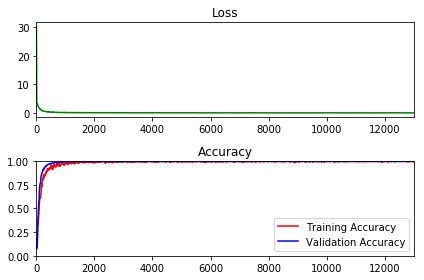

In [27]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label = 'Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label = 'Validation Accuracy')
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.set_ylim([0, 1.0])
acc_plot.legend(loc = 4)
plt.tight_layout()
plt.show()

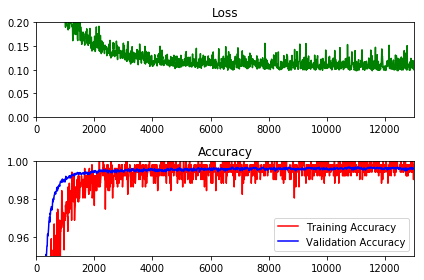

Validation accuracy at 0.9959197640419006
Test accuracy at 0.9707052111625671


In [28]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
loss_plot.set_ylim([0, 0.2])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0.95, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc = 4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))
print('Test accuracy at {}'.format(test_accuracy))
session.close()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** Adam Optimizer was used to train the model; several batch size numbers were tried, and an acceptable compromise between speed and accuracy was found for a batch size of 512.  Better result could be possible with more epochs and further hyperparameter tuning.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** First, the LeNet implementation in the classroom was applied to this problem, but the performance was not so good as I expected, so I extended the network structure to extract low level features, then higher level features, and combined with the regularization of weights to improve the result.

The model was trained using stochastic gradient descent at the beginning, then changed to Adam Optimizer, because Adaptive Moment Estimation method works well in practice and compares favorably to other adaptive learning-method algorithms.

A convolutional layer doesn't fully connect on each layer, and shares weights.  It can learn special features from images, so it's very suitable for this classification problem.  Extending the LeNet structure to include more convolutional layers improved the performance greatly.

ReLUs are used in all but the output layer which is just a linear layer out of which the cross-entropy gets calculated.  Empirically, ReLUs work better than other activation functions, like softmax or tanh.  They may guarantee good convergence during training.

If time allows or computing resources are enough, hyperparameter tuning over learning rate, regularization, epochs, mu, sigma, and dropout, should be performed by grid search, or run in parallel.  To choose the best parameter set, both the speed and the accuracy need considering.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

['33.jpg', '13.jpg', '27.jpg', '25.jpg', '37.jpg']


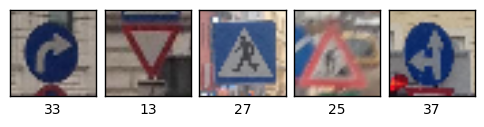

In [41]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import cv2

figure, axes = plt.subplots(1, 5)
figure.subplots_adjust(hspace=0.2, wspace=0.1)
new_images = glob.glob('*.jpg')
print(new_images)
y_new = [int(y[:2]) for y in new_images]
X_new = []
for new_image in new_images:
    new_image = plt.imread(new_image)
    size = min(new_image.shape[:2])
    X_new.append(cv2.resize(new_image[:size, :size], (32, 32), interpolation =cv2.INTER_CUBIC))
    
for i, ax in enumerate(axes.flat):
    ax.imshow(X_new[i].squeeze())
    ax.set_xlabel("{0}".format(y_new[i]))
    ax.set_xticks([])
    ax.set_yticks([])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** Candidate images are taken from the web, generated by the Google map.  Traffic pictures captured through a moving vehicle leading to motion blur and perspective distortions make classification more challenging.  Especially, the 'Pedestrians' sign doesn't show up in the traing set in this form.

In [42]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
X_new = np.array([preprocessing(img) for img in X_new], dtype = np.float32)
y_new = lb.transform(y_new).astype(np.float32)

session = tf.Session()
session.run(init)
saver.restore(session, './models/traffic_sign.ckpt')

new_feed_dict = {x_image: X_new, y_true: y_new, keep_prob: 1.0}
new_accuracy = session.run(accuracy, feed_dict = new_feed_dict)
print('New accuracy at {}'.format(new_accuracy))

New accuracy at 0.800000011920929


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The model predicted 4 out of 5 signs correctly, so it's 80% accurate.  Compared to testing on the dataset, this classifier is not able to perform equally well on captured pictures.  The 'Pedestrians' sign didn't get recognized, but for others that appear in the training set, it gives out correct predictions.

In [43]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
y_new_predicted = session.run(tf.nn.top_k(y_pred, 5), feed_dict = new_feed_dict)
y_new_predicted.values.round(2), y_new_predicted.indices

(array([[ 0.56      ,  0.36000001,  0.02      ,  0.01      ,  0.01      ],
        [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.38999999,  0.37      ,  0.19      ,  0.01      ,  0.01      ],
        [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ]], dtype=float32),
 array([[33, 35, 37, 34,  1],
        [13,  1, 17, 14, 12],
        [38, 18, 20, 36, 25],
        [25, 11, 24, 18, 20],
        [37, 35, 18, 39, 26]], dtype=int32))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** For correct predictions, the model is at least more than 50% certain; for the traffic sign not appearing in the training set, it tends to predict as more general class.  According to the count of each kind, balancing data maybe improve the result.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.